<a href="https://colab.research.google.com/github/insaneDX/Deep-learning-Coding-Challenge/blob/main/credit_card_customer_churn_modelling_with_ann.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [37]:
!pip install sweetviz
!pip install shap

In [38]:
# Importing necessary libraries
import pandas as pd
import numpy as np
import torch
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader, TensorDataset, random_split
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
import matplotlib.pyplot as plt
import seaborn as sns
import sweetviz as sv


import warnings
warnings.filterwarnings("ignore", category=FutureWarning)

------------------------ Data Preprocessing ------------------------

In [39]:
# Load the dataset
df = pd.read_csv('Churn_Modelling.csv')

In [40]:
# Drop unnecessary columns
df.drop(columns=['RowNumber', 'CustomerId', 'Surname'], inplace=True)

In [41]:
# Analyze the class distribution (optional for understanding data)
print("Geography Distribution:\n", df['Geography'].value_counts(normalize=True))
print("\nExited Distribution by Geography:\n", df.groupby('Geography')['Exited'].value_counts(normalize=True))
print("\nExited Distribution by Gender:\n", df.groupby('Gender')['Exited'].value_counts(normalize=True))

Geography Distribution:
 Geography
France     0.5014
Germany    0.2509
Spain      0.2477
Name: proportion, dtype: float64

Exited Distribution by Geography:
 Geography  Exited
France     0         0.838452
           1         0.161548
Germany    0         0.675568
           1         0.324432
Spain      0         0.833266
           1         0.166734
Name: proportion, dtype: float64

Exited Distribution by Gender:
 Gender  Exited
Female  0         0.749285
        1         0.250715
Male    0         0.835441
        1         0.164559
Name: proportion, dtype: float64


# EDA

In [42]:
class EDA:
    """
    A class to perform Exploratory Data Analysis (EDA) on a dataset.
    """
    def __init__(self, df):
        """
        Initialize the EDA class with a DataFrame.
        """
        self.df = df

    def check_missing_values(self):
        """
        Check for missing values in the dataset.
        """
        missing = self.df.isnull().sum()
        print("Missing Values in Each Column:\n", missing[missing > 0])

    def basic_statistics(self):
        """
        Display basic statistics and data structure information.
        """
        print("Dataset Shape:", self.df.shape)
        print("\nData Types and Non-Null Counts:\n", self.df.info())
        print("\nStatistical Summary:\n", self.df.describe())

    def plot_class_distribution(self, target_column):
        """
        Plot the distribution of the target column (class labels).
        """
        plt.figure(figsize=(6, 4))
        sns.countplot(x=target_column, data=self.df, palette='viridis')
        plt.title("Class Distribution")
        plt.xlabel(target_column)
        plt.ylabel("Count")
        plt.show()

    def plot_categorical_features(self, categorical_columns, target_column):
        """
        Plot the relationship between categorical features and the target column.
        """
        for col in categorical_columns:
            plt.figure(figsize=(6, 4))
            sns.countplot(x=col, hue=target_column, data=self.df, palette='husl')
            plt.title(f"{col} vs {target_column}")
            plt.xlabel(col)
            plt.ylabel("Count")
            plt.legend(title=target_column)
            plt.show()

    def plot_numerical_features(self, numerical_columns):
        """
        Plot the distributions of numerical features.
        """
        for col in numerical_columns:
            plt.figure(figsize=(6, 4))
            sns.histplot(self.df[col], kde=True, color='blue', bins=30)
            plt.title(f"Distribution of {col}")
            plt.xlabel(col)
            plt.ylabel("Frequency")
            plt.show()

    def plot_correlation_matrix(self):
        """
        Plot a correlation matrix heatmap.
        """
        # Select only numeric columns for correlation

        numeric_df = self.df.select_dtypes(include=[np.number])

        plt.figure(figsize=(10, 8))
        corr_matrix = numeric_df.corr()
        sns.heatmap(corr_matrix, annot=True, cmap="coolwarm", fmt=".2f")
        plt.title("Correlation Matrix")
        plt.show()

    def report(self):
        # Create the analysis report
        report = sv.analyze(df)

        # Save the report to an HTML file
        report.show_html("sweetviz_report.html")



Missing Values in Each Column:
 Series([], dtype: int64)
Dataset Shape: (10000, 11)
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10000 entries, 0 to 9999
Data columns (total 11 columns):
 #   Column           Non-Null Count  Dtype  
---  ------           --------------  -----  
 0   CreditScore      10000 non-null  int64  
 1   Geography        10000 non-null  object 
 2   Gender           10000 non-null  object 
 3   Age              10000 non-null  int64  
 4   Tenure           10000 non-null  int64  
 5   Balance          10000 non-null  float64
 6   NumOfProducts    10000 non-null  int64  
 7   HasCrCard        10000 non-null  int64  
 8   IsActiveMember   10000 non-null  int64  
 9   EstimatedSalary  10000 non-null  float64
 10  Exited           10000 non-null  int64  
dtypes: float64(2), int64(7), object(2)
memory usage: 859.5+ KB

Data Types and Non-Null Counts:
 None

Statistical Summary:
         CreditScore           Age        Tenure        Balance  NumOfProducts  \
cou

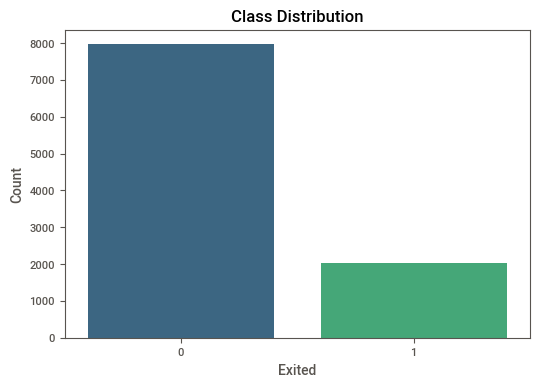

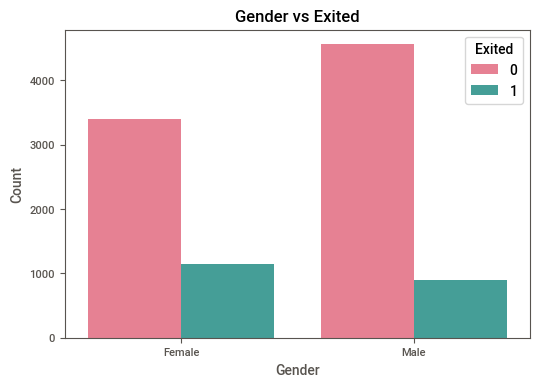

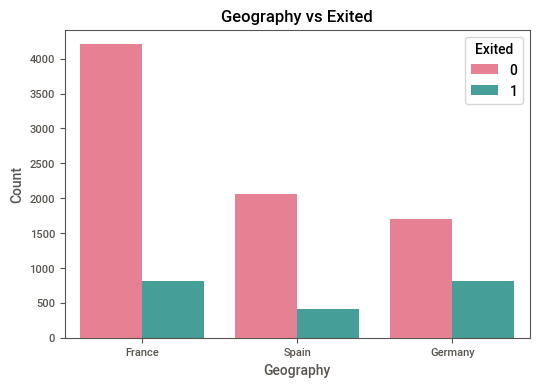

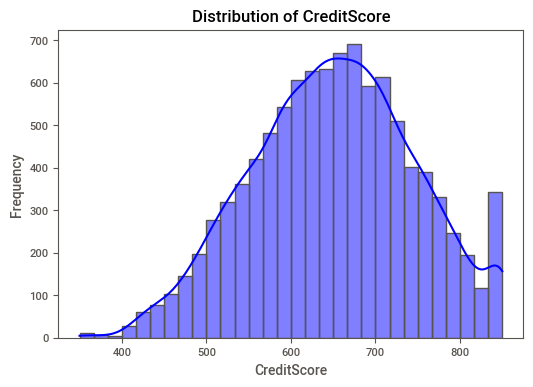

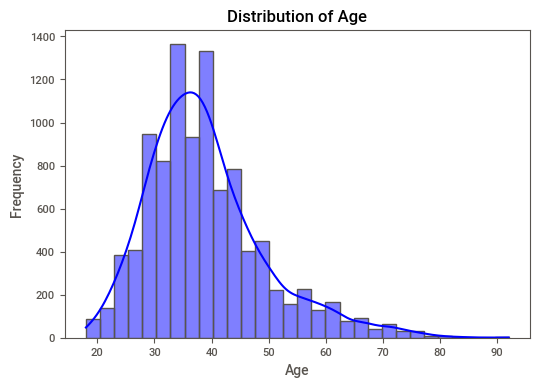

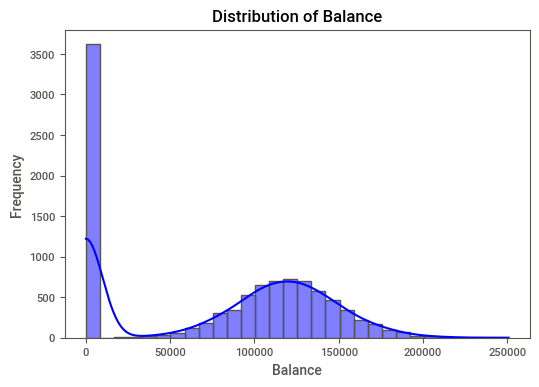

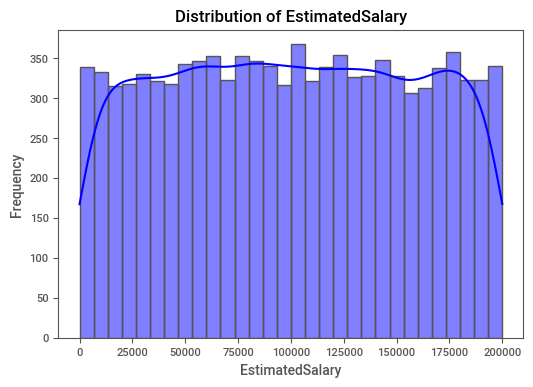

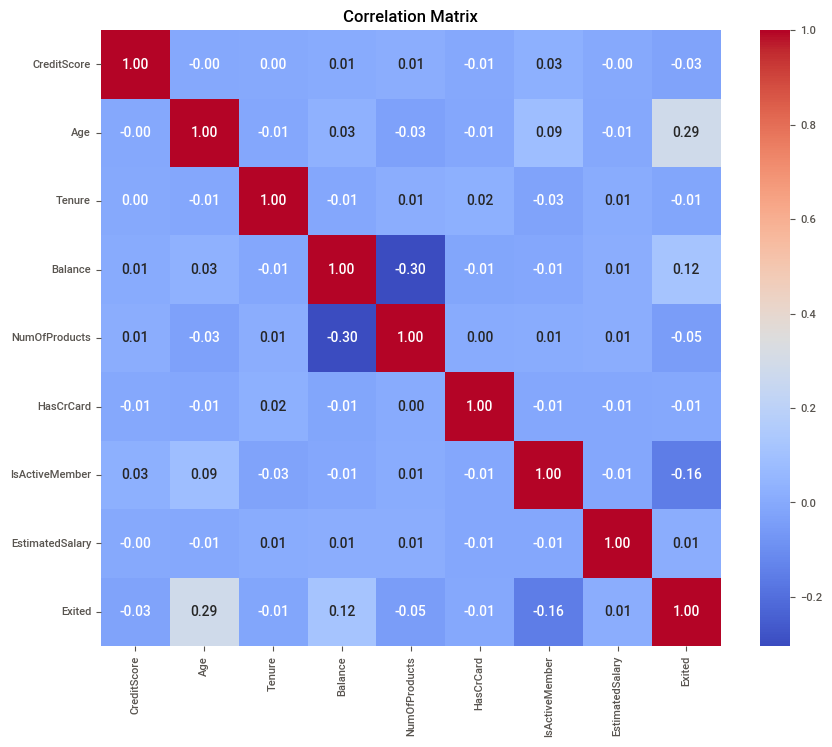

                                             |          | [  0%]   00:00 -> (? left)

Report sweetviz_report.html was generated! NOTEBOOK/COLAB USERS: the web browser MAY not pop up, regardless, the report IS saved in your notebook/colab files.


In [43]:
# Instantiate the EDA class
eda = EDA(df)

# Check for missing values
eda.check_missing_values()

# Display basic statistics and info
eda.basic_statistics()

# Plot class distribution
eda.plot_class_distribution(target_column='Exited')

# Plot categorical features vs target
categorical_columns = ['Gender', 'Geography']
eda.plot_categorical_features(categorical_columns, target_column='Exited')

# Plot numerical feature distributions
numerical_columns = ['CreditScore', 'Age', 'Balance', 'EstimatedSalary']
eda.plot_numerical_features(numerical_columns)

# Plot correlation matrix
eda.plot_correlation_matrix()

# Generate a Sweetviz report
eda.report()


Key Observations on above heatmap:
1. Age and Exited: Positive Correlation (0.29): As age increases, the likelihood of exiting increases.
2. Balance and NumOfProducts: Negative Correlation (-0.30): Higher balances are associated with fewer products.
3. IsActiveMember and Exited: Negative Correlation (-0.16): Active members are less likely to exit.

In [44]:
# Convert categorical variables into dummy/one-hot encoded variables
df = pd.get_dummies(df, columns=['Gender', 'Geography'], drop_first=True)

In [45]:
# Define input (X) and output (y) variables
X = df.drop(columns=['Exited'])  # Features
y = df['Exited'].values          # Target variable

In [46]:
# Split dataset into training and test sets
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)

In [79]:
# Standardize the features
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

/usr/local/lib/python3.10/dist-packages/sklearn/base.py:486: UserWarning: X has feature names, but StandardScaler was fitted without feature names
  warnings.warn(


------------------------ PyTorch Dataset Preparation ------------------------

In [80]:
# Convert data into PyTorch tensors
X_train_tensor = torch.tensor(X_train_scaled, dtype=torch.float32)
y_train_tensor = torch.tensor(y_train, dtype=torch.float32)
X_test_tensor = torch.tensor(X_test_scaled, dtype=torch.float32)
y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

<ipython-input-80-da179a9fe00f>:3: UserWarning: To copy construct from a tensor, it is recommended to use sourceTensor.clone().detach() or sourceTensor.clone().detach().requires_grad_(True), rather than torch.tensor(sourceTensor).
  y_train_tensor = torch.tensor(y_train, dtype=torch.float32)


------------------------ ANN Model Definition ------------------------

In [81]:
class ANNModel(nn.Module):
    """
    A simple Artificial Neural Network (ANN) with two hidden layers.
    """
    def __init__(self, input_dim):
        super(ANNModel, self).__init__()
        self.layer1 = nn.Linear(input_dim, 11)  # Input Layer -> First Hidden Layer
        self.activation1 = nn.ReLU()
        self.layer2 = nn.Linear(11, 11)        # First Hidden Layer -> Second Hidden Layer
        self.activation2 = nn.ReLU()
        self.output_layer = nn.Linear(11, 1)   # Second Hidden Layer -> Output Layer
        self.output_activation = nn.Sigmoid()  # Sigmoid for binary classification

    def forward(self, x):
        x = self.activation1(self.layer1(x))
        x = self.activation2(self.layer2(x))
        x = self.output_activation(self.output_layer(x))
        return x

------------------------ Model Training ------------------------

In [82]:
# Instantiate the model
input_dim = X_train.shape[1]  # Number of input features
model = ANNModel(input_dim)

Epoch [1/100], Train Loss: 0.37928776629269123, Val Loss: 0.3726990222930908
Epoch [2/100], Train Loss: 0.37624554708600044, Val Loss: 0.3758101612329483
Epoch [3/100], Train Loss: 0.37525819800794125, Val Loss: 0.37830547243356705
Epoch [4/100], Train Loss: 0.3737503979355097, Val Loss: 0.3803517445921898
Epoch [5/100], Train Loss: 0.37290230579674244, Val Loss: 0.38328074663877487
Epoch [6/100], Train Loss: 0.3722452837973833, Val Loss: 0.3846898227930069
Epoch [7/100], Train Loss: 0.3710097223520279, Val Loss: 0.38590601086616516
Epoch [8/100], Train Loss: 0.37053910829126835, Val Loss: 0.38646069169044495
Epoch [9/100], Train Loss: 0.37013825960457325, Val Loss: 0.38795793801546097
Epoch [10/100], Train Loss: 0.3693284150213003, Val Loss: 0.38960161805152893
Epoch [11/100], Train Loss: 0.36878202855587006, Val Loss: 0.3910543993115425
Epoch [12/100], Train Loss: 0.36820467188954353, Val Loss: 0.3916632980108261
Epoch [13/100], Train Loss: 0.3680220916867256, Val Loss: 0.39164579659

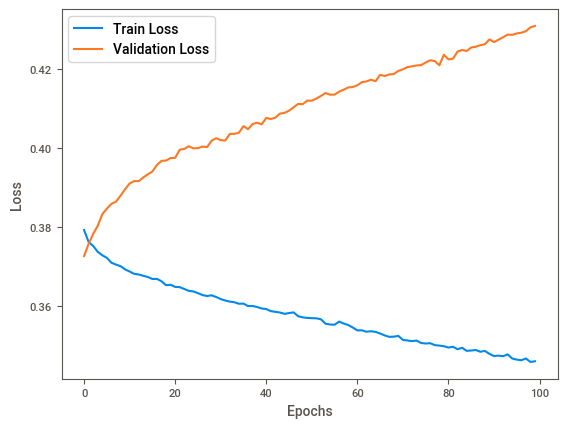

In [93]:
class Trainer:
    def __init__(self, model, train_loader, val_loader, criterion, optimizer, epochs=80):
        self.model = model
        self.train_loader = train_loader
        self.val_loader = val_loader
        self.criterion = criterion
        self.optimizer = optimizer
        self.epochs = epochs
        self.train_losses = []
        self.val_losses = []

    def train(self):
        for epoch in range(self.epochs):
            self.model.train()
            train_loss = 0.0
            for batch_X, batch_y in self.train_loader:
                self.optimizer.zero_grad()
                outputs = self.model(batch_X)
                loss = self.criterion(outputs.squeeze(), batch_y)
                loss.backward()
                self.optimizer.step()
                train_loss += loss.item()

            train_loss /= len(self.train_loader)
            self.train_losses.append(train_loss)

            # Validation Phase
            self.model.eval()
            val_loss = 0.0
            with torch.no_grad():
                for batch_X, batch_y in self.val_loader:
                    outputs = self.model(batch_X)
                    loss = self.criterion(outputs.squeeze(), batch_y)
                    val_loss += loss.item()

            val_loss /= len(self.val_loader)
            self.val_losses.append(val_loss)

            print(f'Epoch [{epoch+1}/{self.epochs}], Train Loss: {train_loss}, Val Loss: {val_loss}')

        print("Training complete")

    def plot_losses(self):
        import matplotlib.pyplot as plt

        plt.plot(self.train_losses, label='Train Loss')
        plt.plot(self.val_losses, label='Validation Loss')
        plt.xlabel('Epochs')
        plt.ylabel('Loss')
        plt.legend()
        plt.show()

# Example usage:

# Define loss function and optimizer
#criterion = nn.BCELoss()  # Binary Cross-Entropy Loss
criterion = nn.BCELoss(weight=torch.tensor([0.625]))

optimizer = optim.Adam(model.parameters())


# Create a dataset and split into training and validation sets
dataset = TensorDataset(X_train_tensor, y_train_tensor)
train_size = int(0.8 * len(dataset))
val_size = len(dataset) - train_size
train_dataset, val_dataset = random_split(dataset, [train_size, val_size])

# Create data loaders
train_loader = DataLoader(train_dataset, batch_size=50, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=50, shuffle=False)

# Create trainer instance and train the model
trainer = Trainer(model, train_loader, val_loader, criterion, optimizer, epochs=100)
trainer.train()

# Plot losses
trainer.plot_losses()


------------------------ Final Testing ------------------------

In [85]:
def test_model(model, X_test, y_test):
    """
    Function to evaluate the model on the test set.
    """
    model.eval()
    X_test_tensor = torch.tensor(X_test, dtype=torch.float32)
    y_test_tensor = torch.tensor(y_test, dtype=torch.float32)

    with torch.no_grad():
        outputs = model(X_test_tensor).squeeze()
        predictions = (outputs > 0.5).float()
        accuracy = (predictions == y_test_tensor).sum().item() / y_test_tensor.size(0)
        print(f"Test Accuracy: {accuracy:.4f}")

In [86]:
# Evaluate on the test set
test_model(model, X_test_scaled, y_test)

Test Accuracy: 0.4940
